In [164]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [165]:
tf.__version__

'2.7.0'

In [166]:
shutil.copy("Data/cAb-rep/cAb-Rep_heavy.nt.fasta", "Data/cAb-rep/cAb-Rep_heavy.nt.txt")

'Data/cAb-rep/cAb-Rep_heavy.nt.txt'

In [174]:
with open("Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    head = [next(myfile) for x in range(2000)]
print(head[1])

AACCTACTGGAGTCTGGGGGAGGCTTAGTCAAGCCAGGAGGGTCCCTGAGACTGTCTTGTGAAGGCTCAGGATTCCTGTTCAGTCACTATTACATGAGTTGGATACGCCAGGGTCCCGAGAAGAGACTGGAGTTGGTTGCATACATTAGCTCCAATAGTACCGCCTTTTATTACGCAGACTCTGTGAAGGGCCGCTTCACCGTTTCCAAGGACGACGCCAAGAAGTCTGTGTTTCTCCAAATGACTTCCGTGTCAAGCGACGACACGGCCACCTATTACTGTGCGACGGGGGATTGGAGTCGTACCAATAACTTCGACACCTGGGGCCAGGGAACCCAGGTCATCGTCTCC



In [175]:
healthy_sequences = []
for i in head:
    if i.find("cdr3_aa_seq=") == -1:
        continue
    inner_str = i.split('cdr3_aa_seq=')[-1].split('size=')[0]
    healthy_sequences.append(inner_str)

In [176]:
df = pandas.read_csv("Data/CoV-AbDab_031022.csv")
df = df[["CDRH3"]]
df = df.head(1000)
df

,CDRH3
0,ARGQLGPWVGVDY
1,ARQGWLRGNFDY
2,ASQLWLRGAFDI
3,ARKGWLRGAFDI
4,ARKGWLRGAFDI
...,...
995,ARDLGPYGMDV
996,ARDLGAYGMDV
997,ARLPYGMDV
998,ARLPYGMDV


In [177]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))
# print(covid_sequences)

28
28


In [178]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

In [103]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    count = 0
    b = np.zeros((28, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((28, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

# set infected 1, healthy 0

1000


In [106]:
healthy_lables = [0] * 1000
covid_lables = [1] * 1000

In [113]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [179]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 20)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  # tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [180]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [181]:
history = model.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val))

Epoch 1/20


2022-11-15 14:38:35.174274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 1s 11ms/step - loss: 0.6870 - accuracy: 0.5025 - val_loss: 0.6646 - val_accuracy: 0.5167
Epoch 2/20
 8/51 [===>..........................] - ETA: 0s - loss: 0.6186 - accuracy: 0.6172

2022-11-15 14:38:35.895096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 0s 8ms/step - loss: 0.6166 - accuracy: 0.6698 - val_loss: 0.6300 - val_accuracy: 0.7389
Epoch 3/20
51/51 [==============================] - 0s 8ms/step - loss: 0.5162 - accuracy: 0.8204 - val_loss: 0.6382 - val_accuracy: 0.7278
Epoch 4/20
51/51 [==============================] - 0s 8ms/step - loss: 0.4238 - accuracy: 0.8852 - val_loss: 0.6764 - val_accuracy: 0.7389
Epoch 5/20
51/51 [==============================] - 0s 8ms/step - loss: 0.3751 - accuracy: 0.9198 - val_loss: 0.8266 - val_accuracy: 0.7500
Epoch 6/20
51/51 [==============================] - 0s 8ms/step - loss: 0.3536 - accuracy: 0.9321 - val_loss: 0.8466 - val_accuracy: 0.7722
Epoch 7/20
51/51 [==============================] - 0s 7ms/step - loss: 0.3284 - accuracy: 0.9444 - val_loss: 0.9237 - val_accuracy: 0.7722
Epoch 8/20
51/51 [==============================] - 0s 7ms/step - loss: 0.3104 - accuracy: 0.9512 - val_loss: 1.0180 - val_accuracy: 0.7722
Epoch 9/20
51/51 [=============

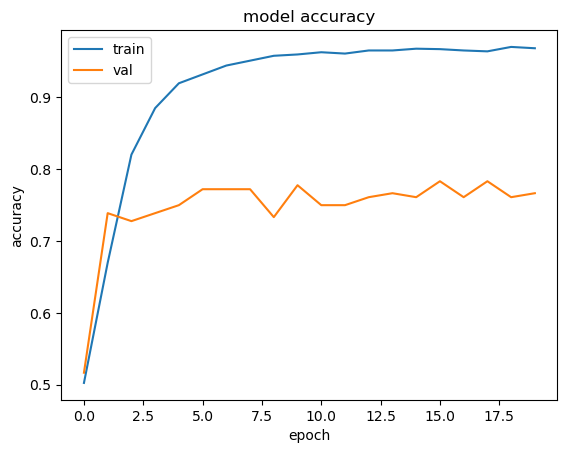

In [182]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [183]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 9ms/step - loss: 1.0097 - accuracy: 0.7750


[1.0096592903137207, 0.7749999761581421]